In [1]:
# Make necessary imports

import pydicom as dicom
import matplotlib.pylab as plt
import cv2 as cv
import os
import math
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

## Visualise original CT and Effusion Scans

In [5]:
# Original Folder
ct_folder = '../Pleural-Effusion/raw_data/ct_scans'
effusion_folder = '../Pleural-Effusion/raw_data/effusion_masks'

# Files
file_name = 'LUNG1-001'

# Read .nii files
ct_scan = nib.load(os.path.join(ct_folder, f'{file_name}.nii'))
effusion_mask = nib.load(os.path.join(effusion_folder, f'{file_name}_effusion.nii'))

# Get imaging data
ct_data = ct_scan.get_fdata()
effusion_data = effusion_mask.get_fdata()

print(ct_data.shape, effusion_data.shape)

(512, 512, 134) (512, 512, 134)


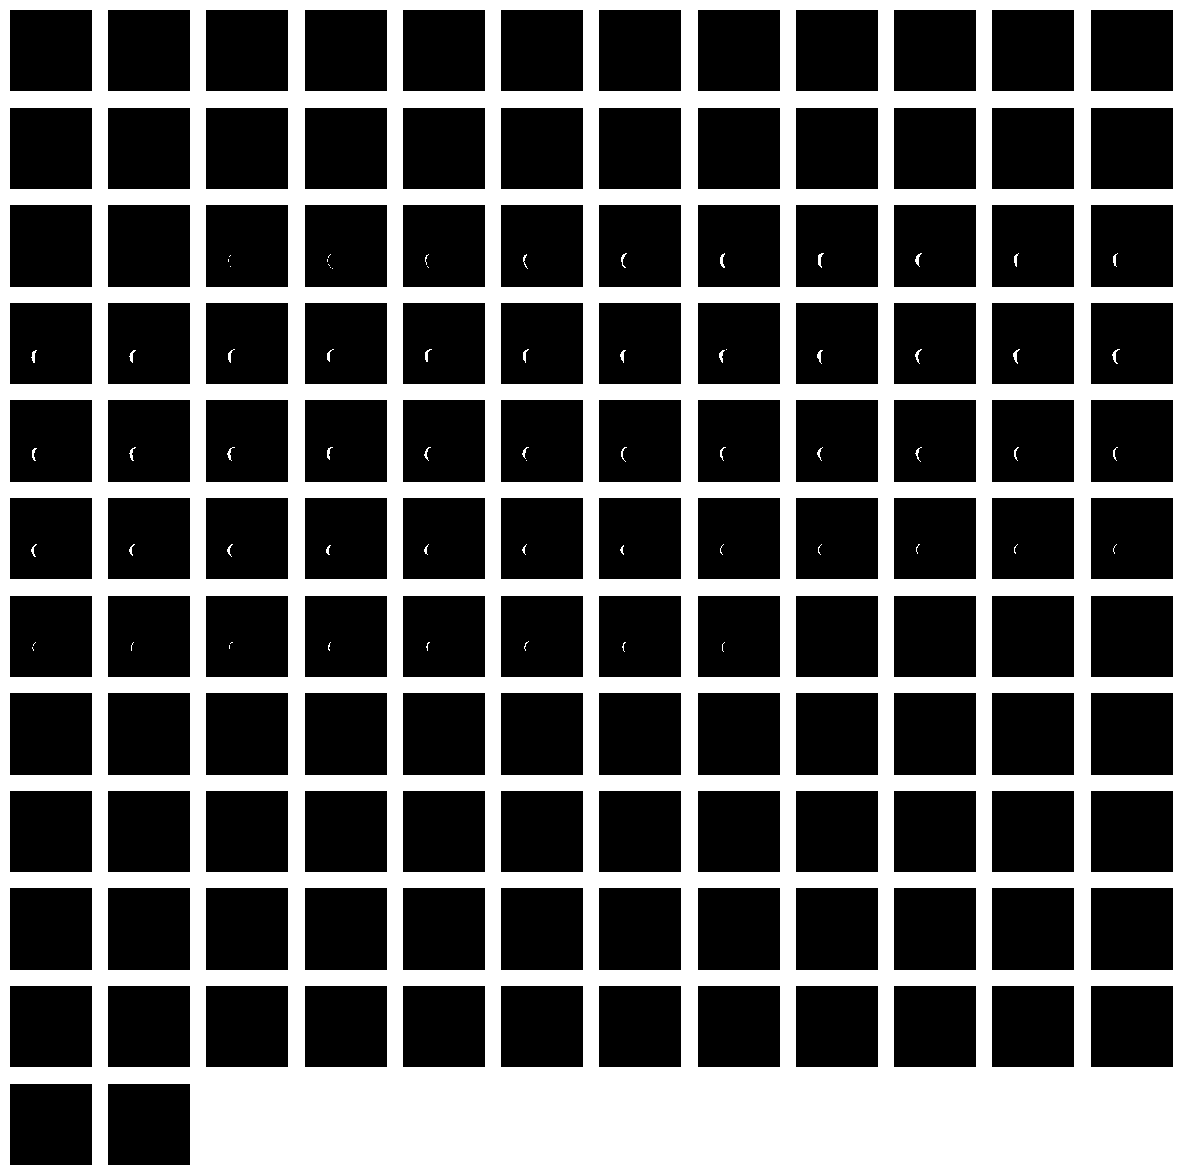

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_channel_grid(scan_data):
    # Get the dimensions of the 3D scan
    depth, height, num_channels = scan_data.shape

    # Calculate the number of rows and columns in the grid
    num_rows = int(np.ceil(np.sqrt(num_channels)))
    num_cols = int(np.ceil(num_channels / num_rows))

    # Plot the square grid of images
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

    for i in range(num_rows):
        for j in range(num_cols):
            channel_idx = i * num_cols + j

            if channel_idx < num_channels:
                # Plot the channel image
                axes[i, j].imshow(scan_data[:, :, channel_idx], cmap='gray', interpolation='nearest')
                axes[i, j].axis('off')
            else:
                # Hide empty subplots
                axes[i, j].axis('off')

    plt.show()

plot_channel_grid(effusion_data)

## Visualize the split testing and training files

In [14]:
# Paths after dividing into traint test split
train_path = '../Pleural-Effusion/split_data/training_data'
test_path = '../Pleural-Effusion/split_data/testing_data'

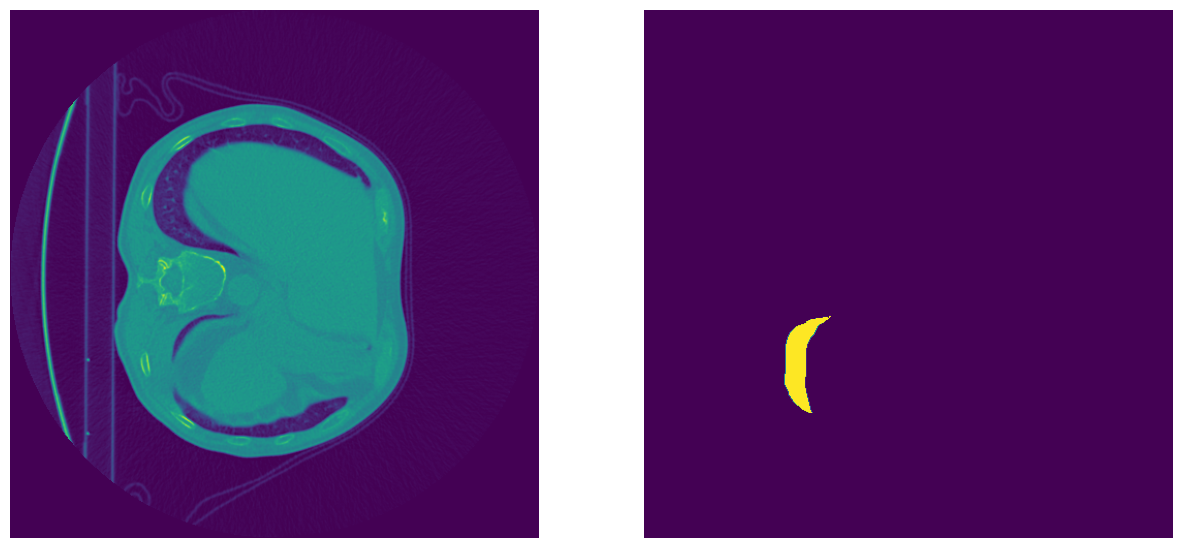

In [16]:
# Load data
split_data_filename = 'LUNG1-001_slice33.npz'
train_data = np.load(os.path.join(train_path, split_data_filename))

# Create subplot
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(train_data['image'])
axes[1].imshow(train_data['label'])
axes[0].axis('off')
axes[1].axis('off')

plt.show()

## Visualise Preprocessed Data

In [17]:
# Paths after dividing into traint test split
preprocess_train_path = '../Pleural-Effusion/preprocessed_data/training_data'
preprocess_test_path = '../Pleural-Effusion/preprocessed_data/testing_data'

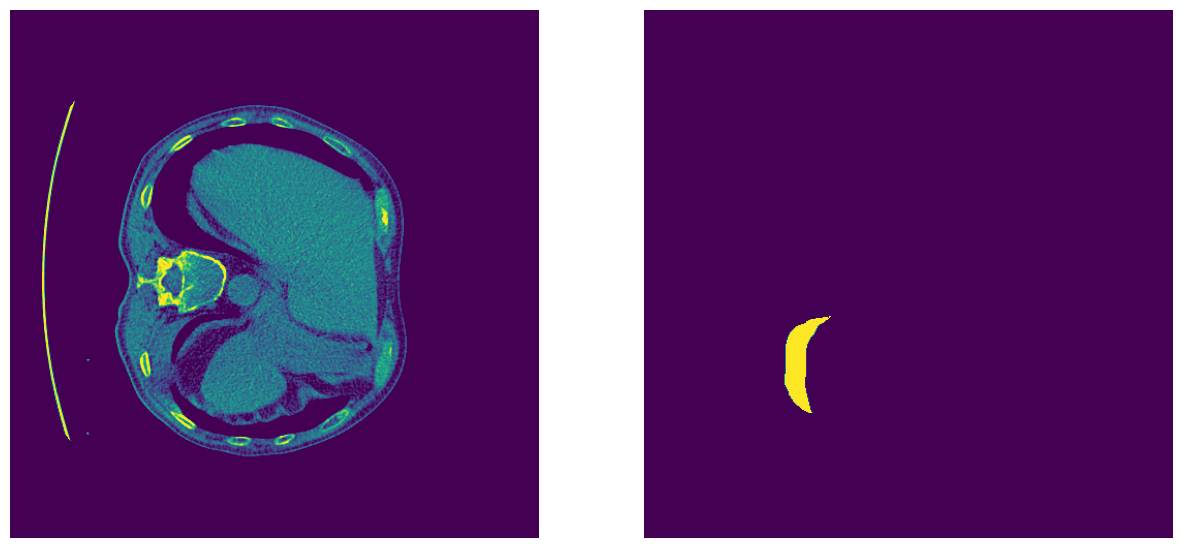

In [19]:
# Load data
preprocess_data_filename = 'LUNG1-001_slice33.npz'
preprocess_data = np.load(os.path.join(preprocess_train_path, preprocess_data_filename))

# Create subplot
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(preprocess_data['image'])
axes[1].imshow(preprocess_data['label'])
axes[0].axis('off')
axes[1].axis('off')

plt.show()